# Trees

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
import pickle
import math

plt.style.use('ggplot')

In [5]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log10(np.exp(model.predict(X))) - np.log10(np.exp(y))) ** 2)))

Here we use decision trees to build models of the sales price

In [33]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.shape

(1460, 279)

## Descision Tree Regressor

In [34]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])


We perform cross-validation to find optimal pruning parameters.

In [35]:
# Create placeholders for the results
min_split = []
scores = []
min_leaf = []

# Set optimization parameters
m_smpl = np.linspace(start=10, stop=100,num=91, dtype='int')
m_lf = np.linspace(2, 7, num=6, dtype='int')

# Run optimization
for smpl in m_smpl:
    for lf in m_lf:
        tree = DecisionTreeRegressor(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)
        cv = cross_val_score(tree,X, y, cv = 10)
        score = np.mean(cv)
        min_split = min_split + [smpl]
        min_leaf = min_leaf + [lf]
        scores = scores + [score]


In [36]:
tmp_ = pd.DataFrame({'score':scores, 'smpl':min_split, 'leaf':min_leaf})

In [37]:
tmp_.sort_values('score', ascending=False).head(20)

,score,smpl,leaf
204,0.802921,44,2
199,0.802823,43,3
198,0.802757,43,2
252,0.802323,52,2
210,0.802220,45,2
234,0.802067,49,2
205,0.802020,44,3
180,0.801920,40,2
246,0.801748,51,2
186,0.801464,41,2


We use optimized parameters (min_amples_split=44 and min_samples_leaf=2) to build the final model.

In [38]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 278)
X_test : (438, 278)
y_train : (1022,)
y_test : (438,)


We perform train test validation

In [39]:
regression_tree = DecisionTreeRegressor(
 min_samples_split=44, min_samples_leaf=2,
  random_state=0)

Model train accuracy (rmsle):  0.06466067744758301
Model test accuracy (rmsle):  0.0779060174185556


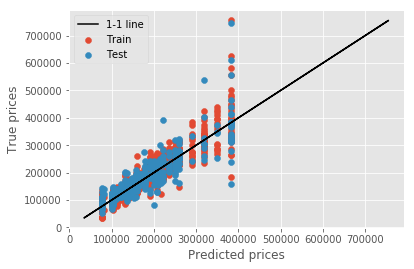

In [40]:
model_tmp = regression_tree.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


Fit to the whole dataset

In [41]:
tree = DecisionTreeRegressor(
 min_samples_split=43, min_samples_leaf=2,
  random_state=0)

tree = tree.fit(X,y)

score_tree = rmsle(tree, X, y)

print('Model accuracy rmse: ', score_tree)

Model accuracy rmse:  0.05735737664928993


In [42]:
importance = pd.DataFrame({'features':X.columns, 'imp':regression_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

importance_top20 = importance.iloc[:20,]

<BarContainer object of 20 artists>

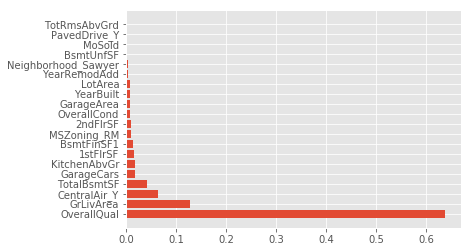

In [43]:
plt.barh(importance_top20.features, importance_top20.imp)

List factors with positive importance

In [44]:
feature_list_dt = list(importance.loc[importance.imp>0,'features'])

In [45]:
# Save features
pickle.dump(obj=feature_list_dt, file=open('./tmp/feaure_list_dt.list','wb'))

## Gradient Boosting

We are using boosted tree to model the prices.

In [46]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

alphas = np.linspace(1, 20, 3)

params = {"max_depth":2, "eta":0.1}
cv_xgb = xgb.cv(params, dtrain,  num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)


[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:09:53] /workspace/sr

[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/sr

[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:53] /workspace/sr

[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/sr

[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/sr

[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/sr

[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:09:54] /workspace/sr

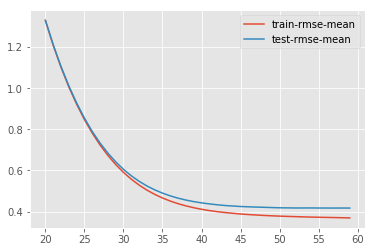

In [47]:
# Plot cv results
cv_xgb.iloc[20:, [0,2]].plot()

Fit to new test and train sets

Model train accuracy (rmsle):  0.05448826569911108
Model test accuracy (rmsle):  0.06066857681177765


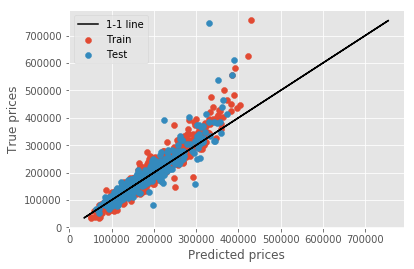

In [48]:
# Fit a model 
model_tmp = xgb.XGBRegressor(n_estimators=60, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_tmp = model_tmp.fit(X_train, y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


Fit to the whole dataset

In [49]:
xgb_mod = xgb.XGBRegressor(n_estimators=60, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
xgb_mod = xgb_mod.fit(X, y)

score_xgb = rmsle(xgb_mod, X, y)

print('Model accuracy rmse: ', score_xgb)


Model accuracy rmse:  0.05580637900633216


## Combine the models

We combine the models and pickle them for use on the train set

In [50]:
# Models

models = ['tree', 'xgb_mod']
scores = [score_tree, score_xgb]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/tree_comb', 'wb'))

     model     score
0     tree  0.057357
1  xgb_mod  0.055806


Pickle models

In [51]:
models_obj = [tree, xgb_mod]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
